# Lesson8 Advanced Computer Vision - 1

## Preprocessing Image

1. Camera Calibration
2. Distortion Correction
3. Color & Gradient Threshold
4. Perspective Transform

## 1. Finding the Lines - Histogram Peaks

After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

Plotting a histogram of where the binary activations occur across the image is one potential solution for this. In the quiz below, let's take a couple quick steps to create our histogram!

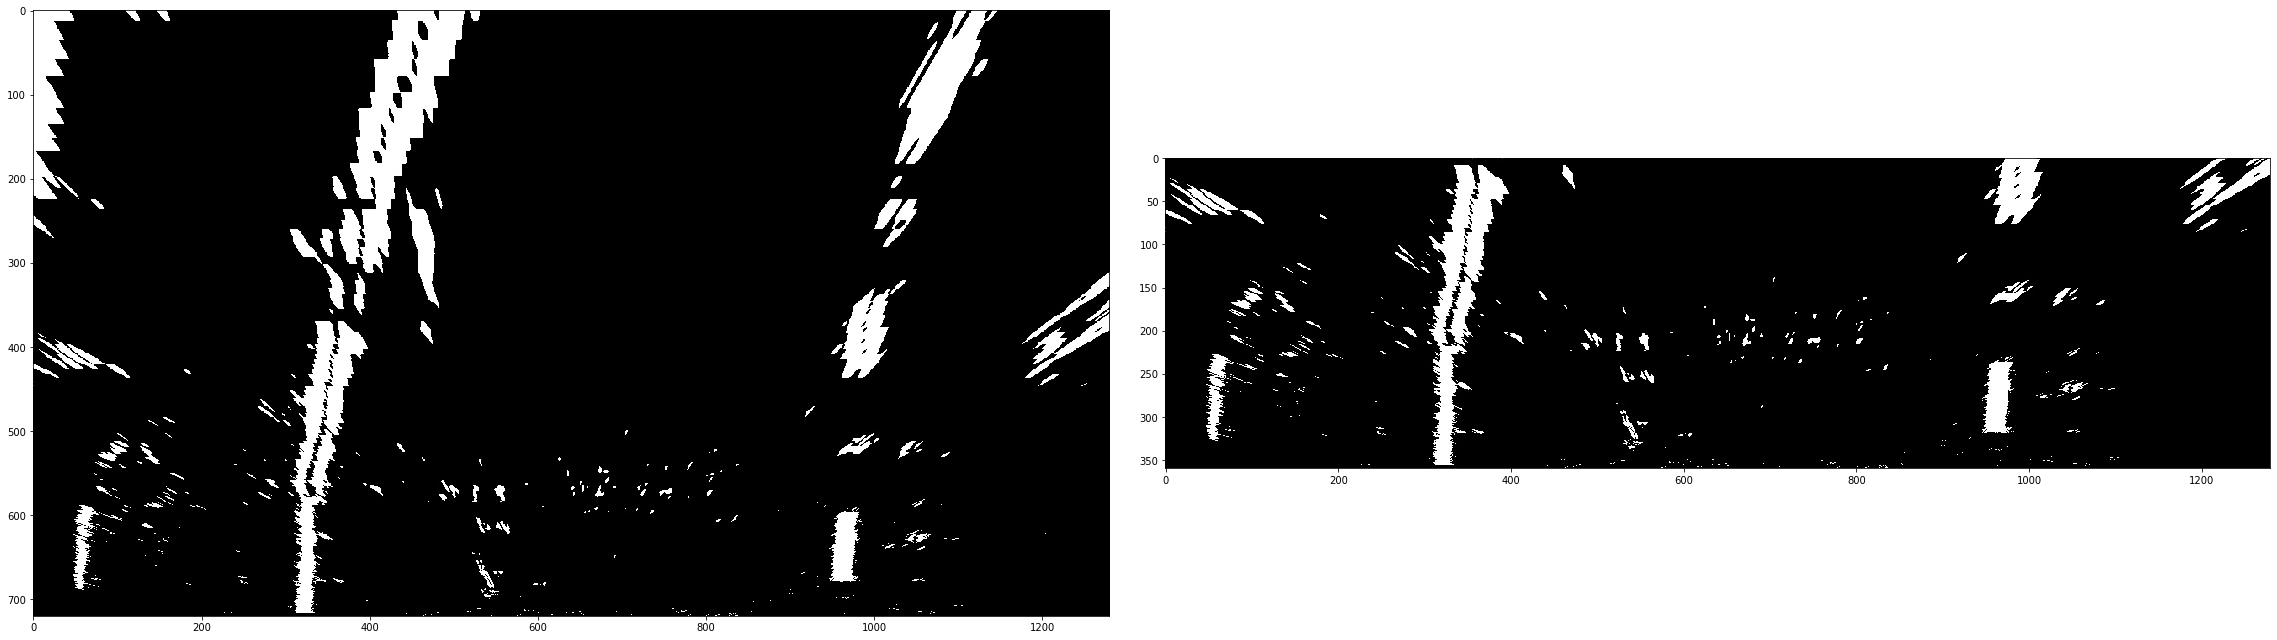

In [64]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('LectureImages/warped_example.jpg')/255

bottom_half = img[int(img.shape[0] / 2):, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (32, 9))
f.tight_layout()
ax1.imshow(img, cmap = 'gray')
ax2.imshow(bottom_half, cmap = 'gray')

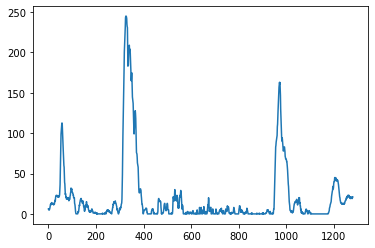

In [65]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # Note : operator '//' means Quotient(몫)

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

## 2. Finding Lane Lines - Sliding Window

<img src="LectureImages/screen-shot-2017-01-28-at-11.49.20-am.png" width="70%" height="70%">

As shown in the previous animation, we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.

### Split the histogram for the two lines
The first step we'll take is to split the histogram into two sides, one for each lane line.

In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming you have created a warped binary image called "binary_warped"
binary_warped = mpimg.imread('LectureImages/warped_example.jpg')

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

### Set up windows and window hyperparameters

Our next step is to set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. We have some base hyperparameters below, but don't forget to try out different values in your own implementation to see what works best!

#### Functions
- <code>np.nonzero()</code> : 배열의 0이 아닌 index를 차원 별로 1D-array로 return   
    - Example
    ```python
    >>> a = np.array([[1, 0, 7], [8, 1, 0], [1, 0, 0]])   
    >>> a.nonzero()
    (array([0, 0, 1, 1, 2]), array([0, 2, 0, 1, 0]))
    ```

    \begin{pmatrix} 1 & 0 & 7 \\ 8 & 1 & 0 \\ 1 & 0 & 0 \end{pmatrix}

    위의 matrix에서 0이 아닌 값을 가지는 배열의 index는 (0,0), (0,2), (1,0), (1,1), (2, 0) 총 다섯개 이고,   
    각각 차원별로 첫번째 인덱스의 경우는 \[0, 0, 1, 1, 2\], 두번째 인덱스의 경우는 \[0, 2, 0, 1, 0\]으로 나타나진다.

    해당 결과를 <code>np.transpose(a.nonzero())</code>로 시켜주면
    ```python
    >>> np.transpose(np.nonzero(a))   
    array([[0, 0], [0, 2], [1, 0], [1, 1], [2, 0]])
    ```
    0이 아닌 index를 얻을 수 있다

In [67]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
# nonzero
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

### Iterate through <code>nwindows</code> to track curvature
Now that we've set up what the windows look like and have a starting point, we'll want to loop for <code>nwindows</code>, with the given window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.

You'll implement this part in the quiz below, but here's a few steps to get you started:

1. Loop through each window in <code>nwindows</code>

2. Find the boundaries of our current window. This is based on a combination of the current window's starting point (<code>leftx_current</code> and <code>rightx_current</code>), as well as the <code>margin</code> you set in the hyperparameters.

3. Use <code>cv2.rectangle</code> to draw these window boundaries onto our visualization image <code>out_img</code>. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.

4. Now that we know the boundaries of our window, find out which activated pixels from <code>nonzeroy</code> and <code>nonzerox</code> above actually fall into the window.

5. Append these to our lists <code>left_lane_inds</code> and <code>right_lane_inds</code>.

6. If the number of pixels you found in Step 4 are greater than your hyperparameter <code>minpix</code>, re-center our window (i.e. <code>leftx_current</code> or <code>rightx_current</code>) based on the mean position of these pixels.

#### Functions
- <code>cv2.rectangle(img, start, end, color, thickness)</code>
    - Parameters:	
        - img – 그림을 그릴 이미지
        - start – 시작 좌표(ex; (0,0))
        - end – 종료 좌표(ex; (500. 500))
        - color – BGR형태의 Color(ex; (255, 0, 0) -> Blue)
        - thickness (int) – 선의 두께. pixel

In [68]:
# Step through the windows one by one
# for window in range(nwindows):
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    ### TO-DO: Find the four below boundaries of the window ###
    win_xleft_low = leftx_current - margin  # Update this
    win_xleft_high = leftx_current + margin  # Update this
    win_xright_low = rightx_current - margin  # Update this
    win_xright_high = rightx_current + margin  # Update this

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),
    (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),
    (win_xright_high,win_y_high),(0,255,0), 2) 

    ### TO-DO: Identify the nonzero pixels in x and y within the window ###
    good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    ### TO-DO: If you found > minpix pixels, recenter next window ###
    ### (`right` or `leftx_current`) on their mean position ###
    if(len(good_left_inds) > minpix):
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if(len(good_right_inds) > minpix):
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

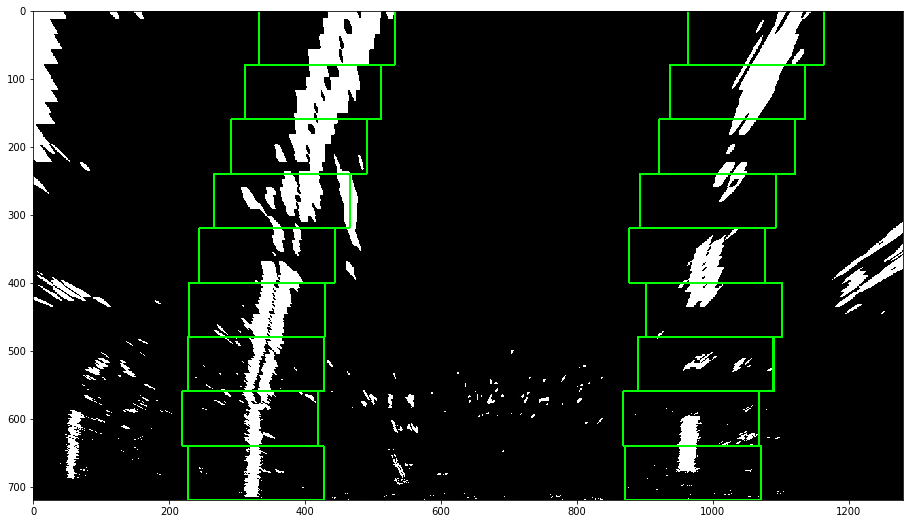

In [69]:
plt.figure(figsize = (24, 9))
plt.imshow(out_img)

### Fit a polynomial
Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line. First, we have a couple small steps to ready our pixels.

In [70]:
# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

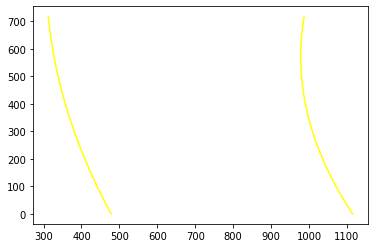

In [71]:
### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

We'll let you implement the function for the polynomial in the quiz below using <code>np.polyfit</code>.

Take note of how we fit the lines above - while normally you calculate a y-value for a given x, here we do the opposite. Why? Because we expect our lane lines to be (mostly) vertically-oriented.

### Visualization
Once you reach this point, you're done! But here is how you can visualize the result as well:

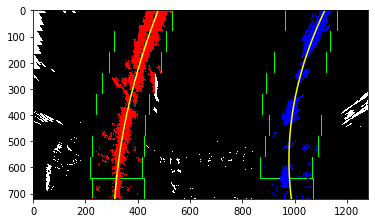

In [72]:
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img)

### Quiz
In the below quiz, implement the following (see <code>TO-DO</code>'s):

* Steps 2, 4 and 6 from above within the for loop in find_lane_pixels() - find the window boundaries, find all pixels within those boundaries, and if there are more than minpix, slide the window over to the mean of these pixels.
* Fit a polynomial to all the relevant pixels you've found in your sliding windows in fit_polynomial().

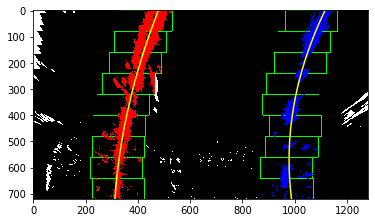

In [73]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('LectureImages/warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

## 3. Finding the Lines: Search from Prior

### Skip the sliding windows step once you've found the lines

<img src = 'LectureImages/screen-shot-2017-01-28-at-12.39.43-pm.png'>

Great work! You've now built an algorithm that uses sliding windows to track the lane lines out into the distance. However, using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image. The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame.

This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

Let's walk through one way to do this, and then you'll build it out further in a quiz below.

### Use the previous polynomial to skip the sliding window
In the previous quiz, we used <code>left_lane_inds</code> and <code>right_lane_inds</code>to hold the pixel values contained within the boundaries of a given sliding window. This time, we'll take the polynomial functions we fit before (<code>left_fit</code> and <code>right_fit</code>), along with a hyperparameter <code>margin</code>, to determine which activated pixels fall into the green shaded areas from the above image. Note that this <code>margin</code> can be a different value than the one originally used for your sliding windows!

To implement this in the below quiz, you'll want to grab only those pixels with x-values that are +/- your <code>margin</code> from your polynomial lines. Note that you'll only need to implement <code>left_lane_inds</code> and <code>right_lane_inds</code> in the quiz - most of the surrounding code, ignoring iterating through the windows, is the same as before!

The way we'll visualize this is a bit different than last time around, however, so make sure to pay attention to that if you want to visualize this step while working on your project.

### Quiz
In the below quiz, implement the following (see <code>TO-DO</code>'s):

Fit a polynomial to all the relevant pixels you've found in your sliding windows in </code>fit_poly()</code>.
Set the area to search for activated pixels based on <code>margin</code> out from your fit polynomial within <code>search_around_poly</code>. Note that the quiz grader expects a <code>margin</code> of <code>100</code> pixels, but you can tune this as part of your own project!

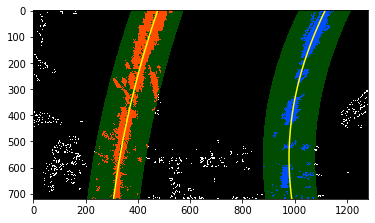

In [96]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('LectureImages/warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * (ploty ** 2) + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * (ploty ** 2) + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

### Fitting on Large Curves
One thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead. If <code>minpix</code> is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window. This will repeat for however many windows are left in <code>nwindows</code>, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit.

Can you think of a way to solve this issue? If you want to tackle the curves on the harder challenge video as part of the project, you might want to include this in your lane finding algorithm.